# **Image Classification Project**

In this project we are going to build a model which can classify cat, dog, horse and human. We are going to use the inceptionV3 model. We are going to load the weights from a pretrained model. Then we will use our model to develop the multiclass classifier. Primarily it can classify cat, dog, horse, human. The dataset for this project is not lagre. The horse and human data are generated using CGI. So, they are not real. However, our model can identify human and horse from real life photo pretty well.

In [199]:
import os
import zipfile
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
from google.colab import files
files.upload()

Saving imgdata.zip to imgdata.zip


In [2]:
path = 'imgdata.zip'
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall()
zip_ref.close()

In [200]:
base_dir = '/content/imgdata'
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
train_humans_dir = os.path.join(train_dir, 'humans') #Directory of our training human pictures
train_horses_dir = os.path.join(train_dir, 'horses') #Directory of our training horse pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures
validation_humans_dir = os.path.join(validation_dir, 'humans') #Directory of our validation human pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') #Directory of our validation horse pictures

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
train_human_fnames = os.listdir( train_humans_dir )
train_horse_fnames = os.listdir( train_horses_dir )
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])
print(train_human_fnames[:10])
print(train_horse_fnames[:10])

In [54]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
train_human_fnames = os.listdir(train_humans_dir)
train_horse_fnames = os.listdir(train_horses_dir)

In [127]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='categorical',# we should use 'binary' for binary image classification
  batch_size=50
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(150,150),
	class_mode='categorical',# we should use 'binary' for binary image classification
  batch_size=20
)


Found 2000 images belonging to 4 classes.
Found 512 images belonging to 4 classes.


In [232]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-11 03:49:00--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   196MB/s    in 0.4s    

2020-09-11 03:49:00 (196 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [202]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, #Just ignoring InceptionV3 fully connected layers
                                weights= None) #  we will load our downloaded weights
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False #freeze the layers in the model
  
#pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed9') #check the summar we can select any arbitrary layer
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


In [204]:
# Flatten the output layer to 1 dimension
x = Flatten()(last_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)   
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)  
x = Dense (4, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(optimizer =tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [206]:
#early_stop=EarlyStopping(monitor='loss',patience=2)
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 40,   # 2000 images=batch_size*steps_per_epoch
            epochs = 100,
            validation_steps = 25)
           

Epoch 1/100
40/40 [==============================] - 20s 505ms/step - loss: 0.5282 - accuracy: 0.8120 - val_loss: 0.1005 - val_accuracy: 0.9660
Epoch 2/100
40/40 [==============================] - 19s 481ms/step - loss: 0.1960 - accuracy: 0.9280 - val_loss: 0.0917 - val_accuracy: 0.9640
Epoch 3/100
40/40 [==============================] - 19s 480ms/step - loss: 0.1457 - accuracy: 0.9425 - val_loss: 0.0711 - val_accuracy: 0.9740
Epoch 4/100
40/40 [==============================] - 19s 478ms/step - loss: 0.1230 - accuracy: 0.9535 - val_loss: 0.0576 - val_accuracy: 0.9820
Epoch 5/100
40/40 [==============================] - 19s 480ms/step - loss: 0.1080 - accuracy: 0.9545 - val_loss: 0.0775 - val_accuracy: 0.9780
Epoch 6/100
40/40 [==============================] - 19s 482ms/step - loss: 0.0946 - accuracy: 0.9665 - val_loss: 0.0913 - val_accuracy: 0.9620
Epoch 7/100
40/40 [==============================] - 19s 481ms/step - loss: 0.0918 - accuracy: 0.9680 - val_loss: 0.0798 - val_accuracy:

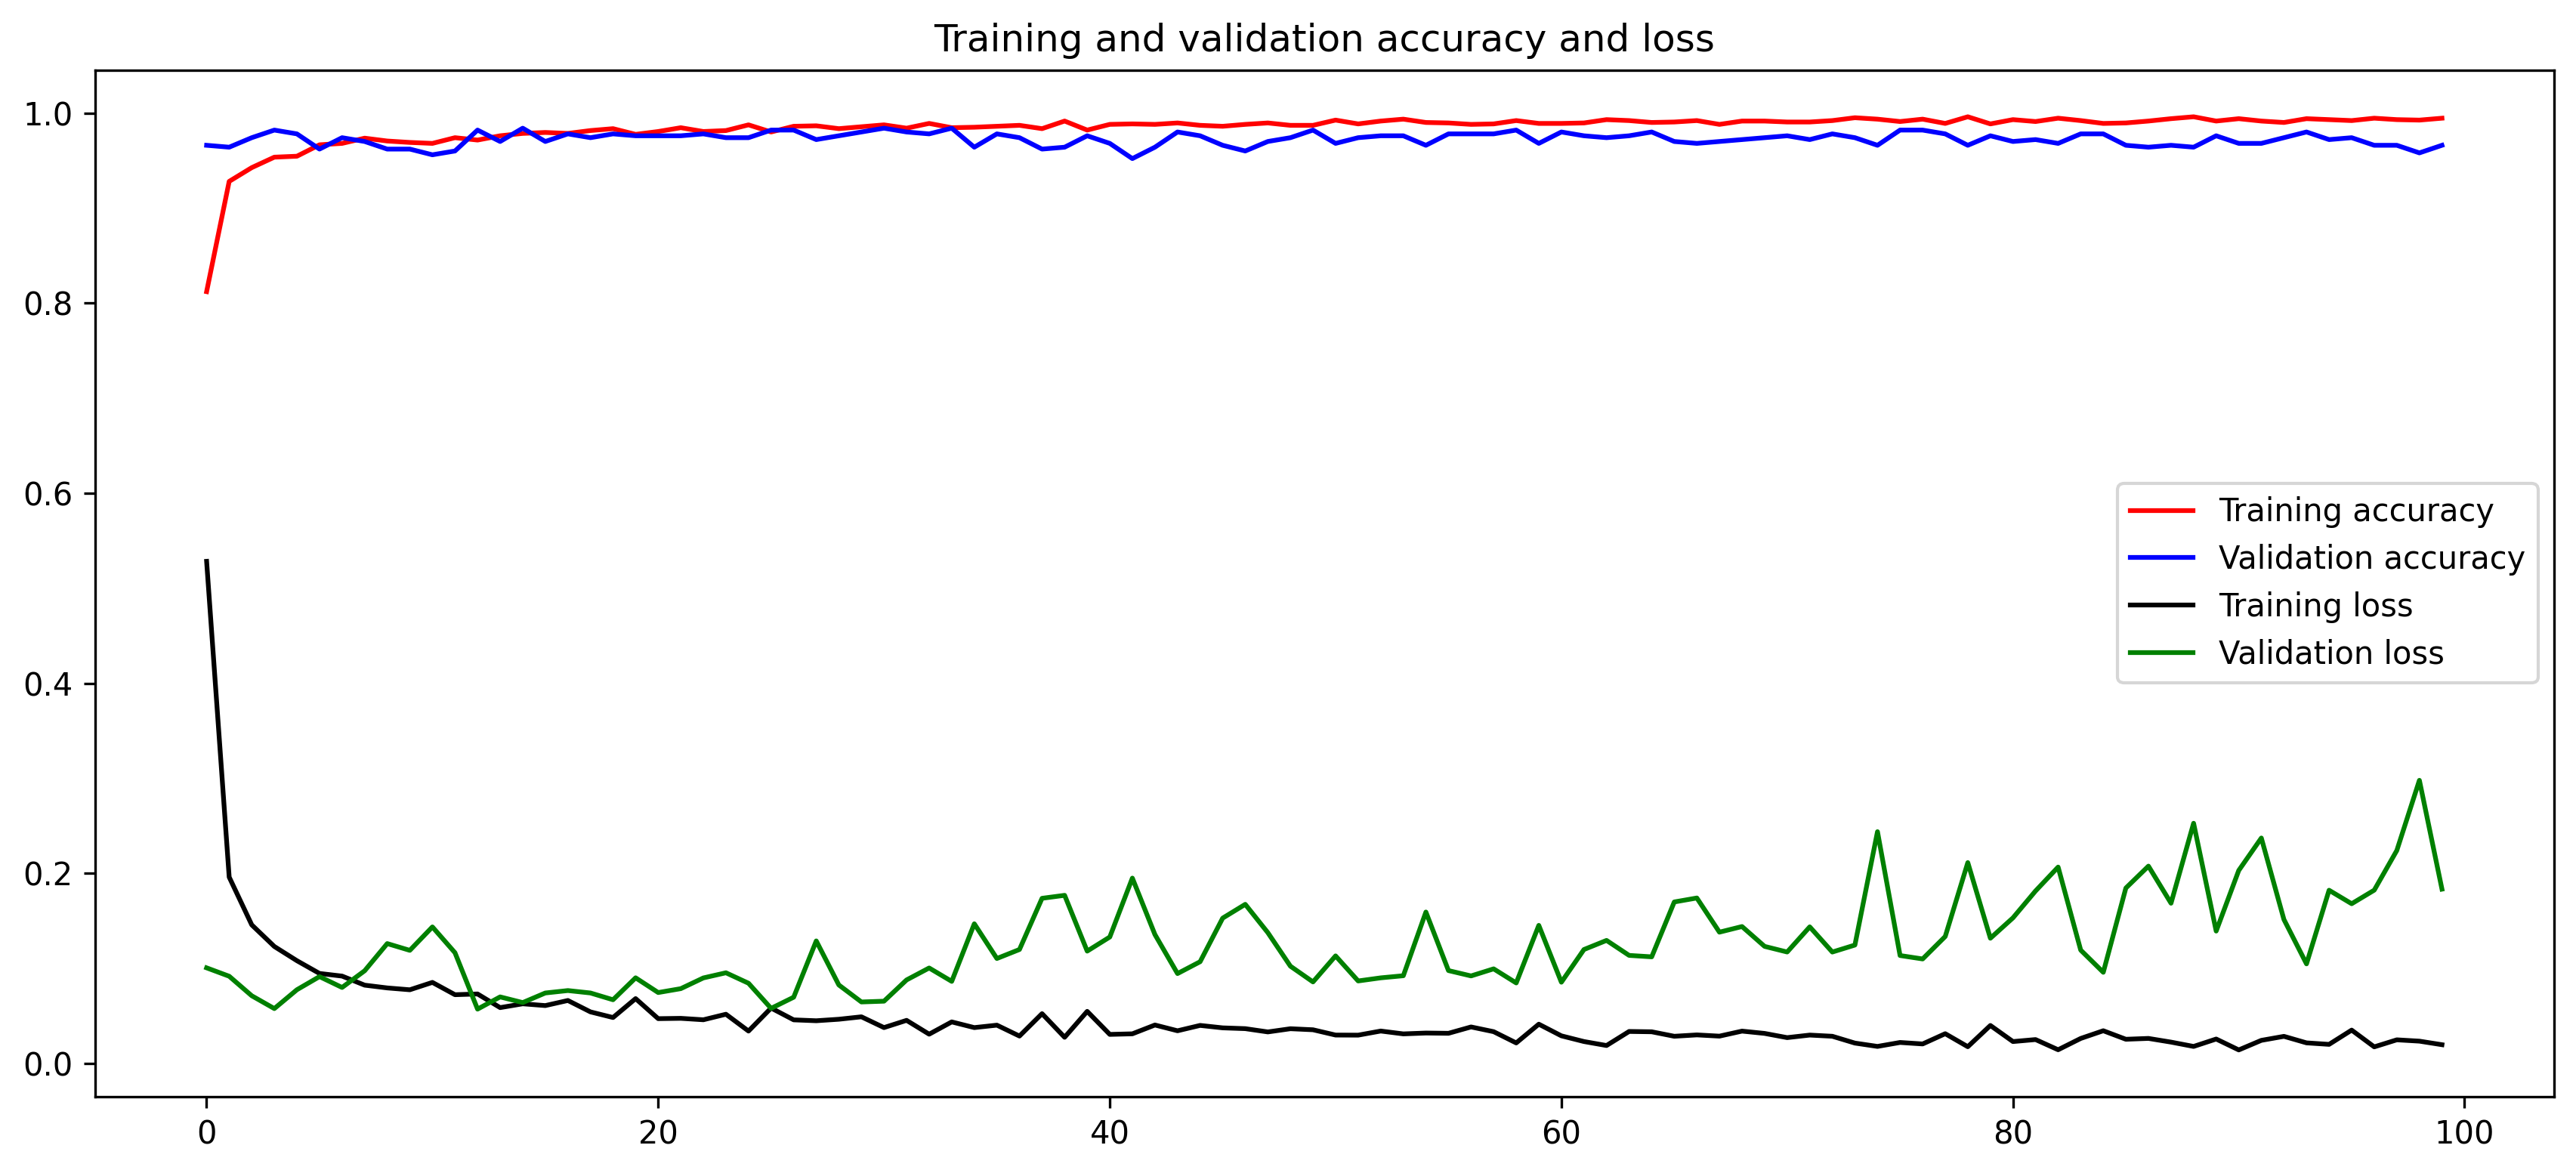

In [208]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(14,6),dpi=300)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'black', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training and validation accuracy and loss')
#plt.legend(loc=0)
plt.legend()

plt.show()

In [224]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
uploaded=files.upload()
for fn in uploaded.keys():
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)/255.0
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images)
  
  print(classes.argmax(axis=1)[0])
  #print(classes[0])
  if classes.argmax(axis=1)[0]==0:
    print(fn + " is a cat")
  elif classes.argmax(axis=1)[0]==1:
    print(fn + " is a dog")
  elif classes.argmax(axis=1)[0]==2:
    print(fn + " is horse")
  else:
    print(fn + " is human")
  


Saving BabyGirlNames_630.jpg to BabyGirlNames_630.jpg
0
BabyGirlNames_630.jpg is a cat
